In [1]:
import numpy as np
# np.bool = np.bool_
import pyarrow #.hdfs
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from pyspark.sql import SparkSession

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("HDFS Parquet Data Analysis") \
    .getOrCreate()

# HDFS에 있는 Parquet 파일의 경로
hdfs_path = "hdfs://hadoop-master:9000/user/root/data/yellow_tripdata_2023-08.parquet"

# HDFS에서 Parquet 파일을 읽어 Spark DataFrame으로 로드
df = spark.read.parquet(hdfs_path)

df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/11 17:03:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



# 데이터 정제

In [5]:
from pyspark.sql import functions as F

# 결측값 확인
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|          87886|            0|     87886|             87886|           0|           0|           0|          0|    0|      0|         

In [6]:
# 결측값 처리 방법:
# 1. 특정 열의 결측값을 대체 (예: 평균값으로)
df = df.fillna({
    'VendorID': 1,
    'passenger_count': df.select(F.mean('passenger_count')).first()[0],
    'trip_distance': df.select(F.mean('trip_distance')).first()[0],
    'RatecodeID': 1,
    'PULocationID': 0,
    'DOLocationID': 0,
    'payment_type': 1,
    'fare_amount': 0.0,
    'extra': 0.0,
    'mta_tax': 0.0,
    'tip_amount': 0.0,
    'tolls_amount': 0.0,
    'improvement_surcharge': 0.0,
    'total_amount': 0.0,
    'congestion_surcharge': 0.0,
    'Airport_fee': 0.0
})

# 2. 결측값이 있는 행 제거 (필요한 경우)
df = df.na.drop()

In [8]:
# 이상값 처리 방법:
# 1. 거리(trip_distance)가 0이거나 음수인 경우 제거
df = df.filter((F.col('trip_distance') > 0))

# 2. 승객 수(passenger_count)가 0이거나 비정상적으로 큰 경우 제거
df = df.filter((F.col('passenger_count') > 0) & (F.col('passenger_count') <= 6))

# 3. 운임 금액(fare_amount)이 음수인 경우 제거
df = df.filter(F.col('fare_amount') >= 0)

# 4. 총 금액(total_amount)이 비정상적으로 큰 경우 (예: 1000달러 이상) 제거
df = df.filter(F.col('total_amount') <= 1000)

In [9]:
# 데이터 타입 강제 변환 및 유효성 검사
df = df.withColumn('VendorID', F.col('VendorID').cast('integer')) \
       .withColumn('passenger_count', F.col('passenger_count').cast('integer')) \
       .withColumn('trip_distance', F.col('trip_distance').cast('double')) \
       .withColumn('RatecodeID', F.col('RatecodeID').cast('integer')) \
       .withColumn('payment_type', F.col('payment_type').cast('integer')) \
       .withColumn('fare_amount', F.col('fare_amount').cast('double')) \
       .withColumn('extra', F.col('extra').cast('double')) \
       .withColumn('mta_tax', F.col('mta_tax').cast('double')) \
       .withColumn('tip_amount', F.col('tip_amount').cast('double')) \
       .withColumn('tolls_amount', F.col('tolls_amount').cast('double')) \
       .withColumn('improvement_surcharge', F.col('improvement_surcharge').cast('double')) \
       .withColumn('total_amount', F.col('total_amount').cast('double')) \
       .withColumn('congestion_surcharge', F.col('congestion_surcharge').cast('double')) \
       .withColumn('Airport_fee', F.col('Airport_fee').cast('double'))

# 유효한 날짜 확인 (픽업 시간이 드롭오프 시간보다 이후일 수 없음)
df = df.filter(F.col('tpep_dropoff_datetime') > F.col('tpep_pickup_datetime'))


In [10]:
# 정제 후 데이터 확인
df.describe().show()

# 스키마 확인
df.printSchema()


24/08/11 17:06:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+
|summary|           VendorID|   passenger_count|     trip_distance|       RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|      fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|
+-------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+----

In [ ]:
# 1.평균 여행 기간
df['mean_time_travel'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [33]:
df['mean_time_travel'].mean()

ConnectionRefusedError: [Errno 111] Connection refused

In [12]:
from pyspark.sql import functions as F

# 여행 기간 계산 (초 단위로)
df = df.withColumn('travel_time', 
                   F.unix_timestamp('tpep_dropoff_datetime') - F.unix_timestamp('tpep_pickup_datetime'))

# 평균 여행 기간 계산
mean_travel_time = df.select(F.mean('travel_time')).collect()[0][0]
print(f"Mean Travel Time: {mean_travel_time} seconds")

Mean Travel Time: 1033.2549056523399 seconds


In [ ]:
# 2.평균 여행 거리
df['trip_distance'].mean()

In [13]:
# 평균 여행 거리 계산
mean_trip_distance = df.select(F.mean('trip_distance')).collect()[0][0]
print(f"Mean Trip Distance: {mean_trip_distance} miles")

Mean Trip Distance: 4.127750333560016 miles


In [ ]:
# 3.시간당 출발하는 여행 수를 기준으로 '피크 시간' 정의
# 하루동안 여행 분포 시각화 -> 값에 따라 강조
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df_hourly_counts = df.groupby(pd.Grouper(key='tpep_pickup_datetime', freq='H')).size()

In [ ]:
# 'timestamp' 열을 인덱스로 설정
df.set_index('tpep_pickup_datetime', inplace=True)

# 시간 단위로 리샘플링하여 레코드 수 세기
df_hourly_counts = df.resample('H').size()
print(df_hourly_counts)

In [ ]:
specific_day='2023-06-30'
s_specific_day = df_hourly_counts[df_hourly_counts.index.date == pd.to_datetime(specific_day).date()]

In [ ]:
s_specific_day

In [ ]:
# 결과 시각화
plt.figure(figsize=(10, 6))
s_specific_day.plot(kind='bar')
plt.title('Peak Time analysis')
plt.xlabel('hour')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

+----+------+
|hour| count|
+----+------+
|   0| 72914|
|   1| 48984|
|   2| 31953|
|   3| 19980|
|   4| 12797|
|   5| 15494|
|   6| 38374|
|   7| 67706|
|   8|100257|
|   9|116454|
|  10|124969|
|  11|132811|
|  12|146348|
|  13|152138|
|  14|161401|
|  15|167257|
|  16|166538|
|  17|175329|
|  18|180951|
|  19|161907|
+----+------+
only showing top 20 rows

+----+-----+
|hour|count|
+----+-----+
+----+-----+



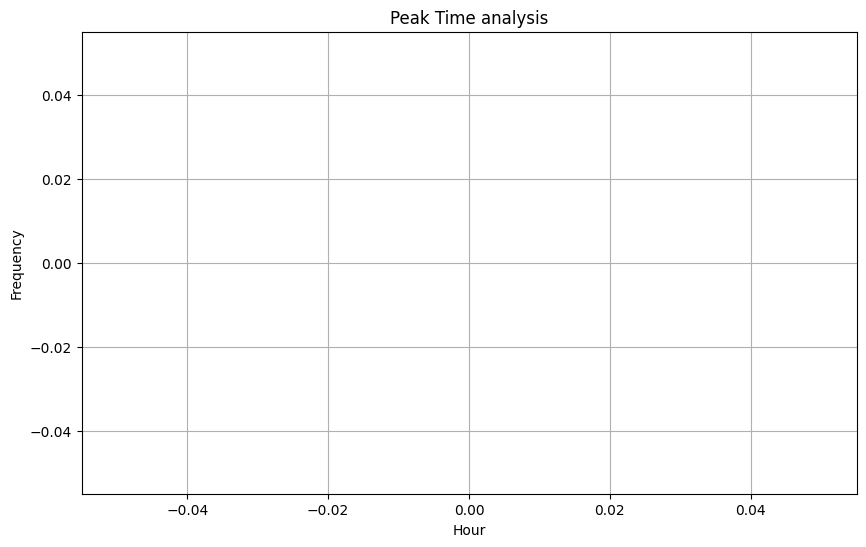

In [15]:
# 'tpep_pickup_datetime' 열에서 시간 정보를 추출하고, 시간 단위로 그룹화하여 여행 수 계산
df_hourly_counts = df.withColumn("hour", F.hour("tpep_pickup_datetime")) \
                     .groupBy("hour") \
                     .count() \
                     .orderBy("hour")

df_hourly_counts.show()

# 특정 일의 데이터 필터링
specific_day = '2023-06-30'
df_specific_day = df.filter(F.to_date(df['tpep_pickup_datetime']) == specific_day)

# 시간 단위로 필터링된 데이터 리샘플링
df_hourly_counts_specific_day = df_specific_day.groupBy(F.hour("tpep_pickup_datetime").alias("hour")) \
                                               .count() \
                                               .orderBy("hour")

df_hourly_counts_specific_day.show()

# 결과 시각화
import matplotlib.pyplot as plt

df_pandas = df_hourly_counts_specific_day.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(df_pandas['hour'], df_pandas['count'])
plt.title('Peak Time analysis')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# 4.여행 + 날씨(기온, 강수량 등)
weather = pd.read_csv('jan_2024_weather_data.csv')
weather['Datetime'] = pd.to_datetime(weather['Datetime'])
weather['Datetime'] = weather['Datetime'] - pd.DateOffset(years=1)
weather

In [ ]:
# 날짜만 추출하여 'date' 열 생성
weather['date'] = weather['Datetime'].dt.date

# 하루의 대표 Condition 계산
representative_condition = weather.groupby('date')['Condition'].agg(lambda x: x.mode()[0])

# 하루의 평균 Temperature 계산
average_temperature = weather.groupby('date')['Temperature'].mean()

# 결과를 하나의 DataFrame으로 결합
result_df = pd.DataFrame({
    'Condition': representative_condition,
    'Average Temperature': average_temperature
})

print(result_df)

In [ ]:
# 2023-01-01부터 2023-05-31까지의 데이터만 필터링
filtered_df = df_hourly_counts['2023-01-01':'2023-05-31']
filtered_df

In [ ]:
date_counts = filtered_df.groupby(filtered_df.index.date).size()
date_counts.name = 'count'
# 날짜를 인덱스에서 열로 변환
date_counts = date_counts.reset_index()
# 열 이름 변경 (인덱스에서 변환된 열의 이름이 'index'이므로 이를 'date'로 변경)
date_counts.rename(columns={'index': 'date'}, inplace=True)
date_counts

In [ ]:
# 병합 수행
merged_df = pd.merge(date_counts, weather, left_on='date', right_on='date', how='outer')

print(merged_df)

In [ ]:
# Condition별 레코드 수 계산
condition_counts = merged_df['Condition'].value_counts()

# Condition별 레코드 수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=condition_counts.index, y=condition_counts.values)
plt.title('Count of Records by Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Temperature별 레코드 수 계산
# Temperature는 문자열이므로, 필요시 숫자로 변환
merged_df['Temperature'] = merged_df['Temperature'].astype(float)
temperature_counts = merged_df['Temperature'].value_counts().sort_index()

# Temperature별 레코드 수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=temperature_counts.index, y=temperature_counts.values)
plt.title('Count of Records by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 날짜별 평균 기온 시각화
plt.figure(figsize=(40, 6))
result_df['Average Temperature'].plot(kind='bar', color='skyblue')
plt.title('Average Temperature by Date')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

+----------+--------------------+-------------------+
|      date|           Condition|Average Temperature|
+----------+--------------------+-------------------+
|2024-01-01|                Fair|  5.787825773938123|
|2024-01-02|                Fair|  2.693187499999981|
|2024-01-03|                Fair|   3.98083333333331|
|2024-01-04|              Cloudy| 3.9223958333333364|
|2024-01-05|        Fair / Windy| 0.4577916666666623|
|2024-01-06|                Fair| 1.5149444444444524|
|2024-01-07|  Light Rain / Windy|  2.782812500000008|
|2024-01-08|       Mostly Cloudy|   4.45152083333337|
|2024-01-09|                Fair|  6.715951388888872|
|2024-01-10|  Heavy Rain / Windy| 10.062062499999927|
|2024-01-11|      Cloudy / Windy|  6.899583333333395|
|2024-01-12|       Mostly Cloudy|   7.31402083333332|
|2024-01-13|  Light Rain / Windy|  9.678291666666702|
|2024-01-14|Mostly Cloudy / W...| 1.8141041666666402|
|2024-01-15|                Fair|-2.8510694444444553|
|2024-01-16|          Light 

+----------+-----+--------------------+-------------------+
|      date|count|           Condition|Average Temperature|
+----------+-----+--------------------+-------------------+
|2024-01-01| NULL|                Fair|  5.787825773938123|
|2024-01-02| NULL|                Fair|  2.693187499999981|
|2024-01-03| NULL|                Fair|   3.98083333333331|
|2024-01-04| NULL|              Cloudy| 3.9223958333333364|
|2024-01-05| NULL|        Fair / Windy| 0.4577916666666623|
|2024-01-06| NULL|                Fair| 1.5149444444444524|
|2024-01-07| NULL|  Light Rain / Windy|  2.782812500000008|
|2024-01-08| NULL|       Mostly Cloudy|   4.45152083333337|
|2024-01-09| NULL|                Fair|  6.715951388888872|
|2024-01-10| NULL|  Heavy Rain / Windy| 10.062062499999927|
|2024-01-11| NULL|      Cloudy / Windy|  6.899583333333395|
|2024-01-12| NULL|       Mostly Cloudy|   7.31402083333332|
|2024-01-13| NULL|  Light Rain / Windy|  9.678291666666702|
|2024-01-14| NULL|Mostly Cloudy / W...| 

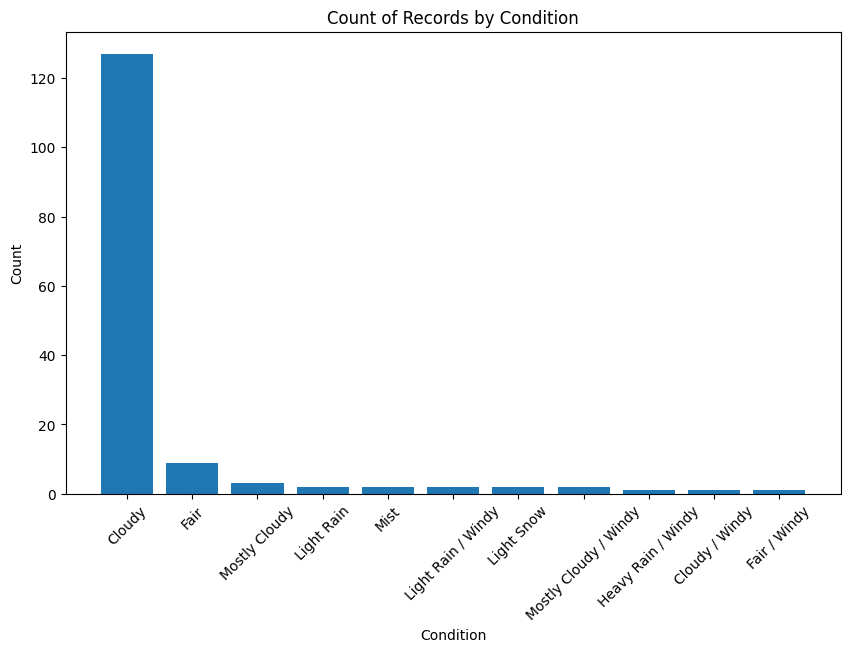

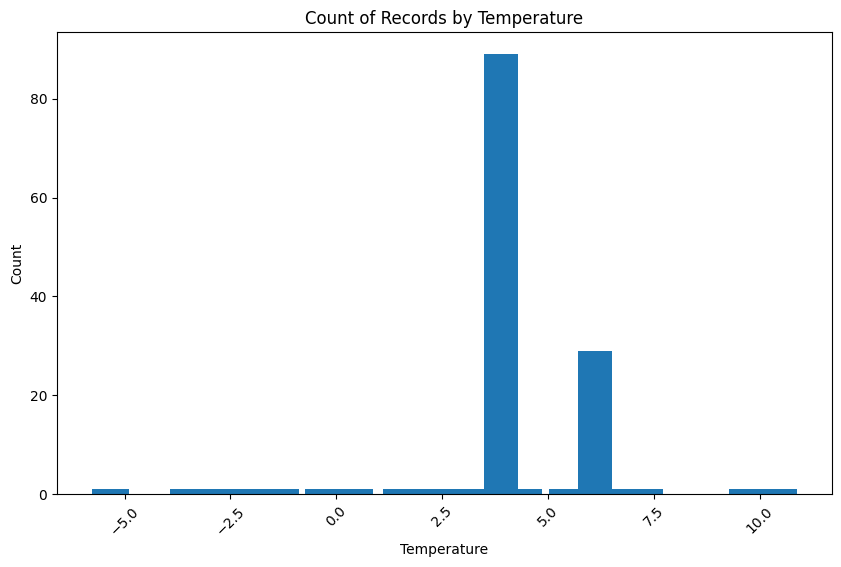

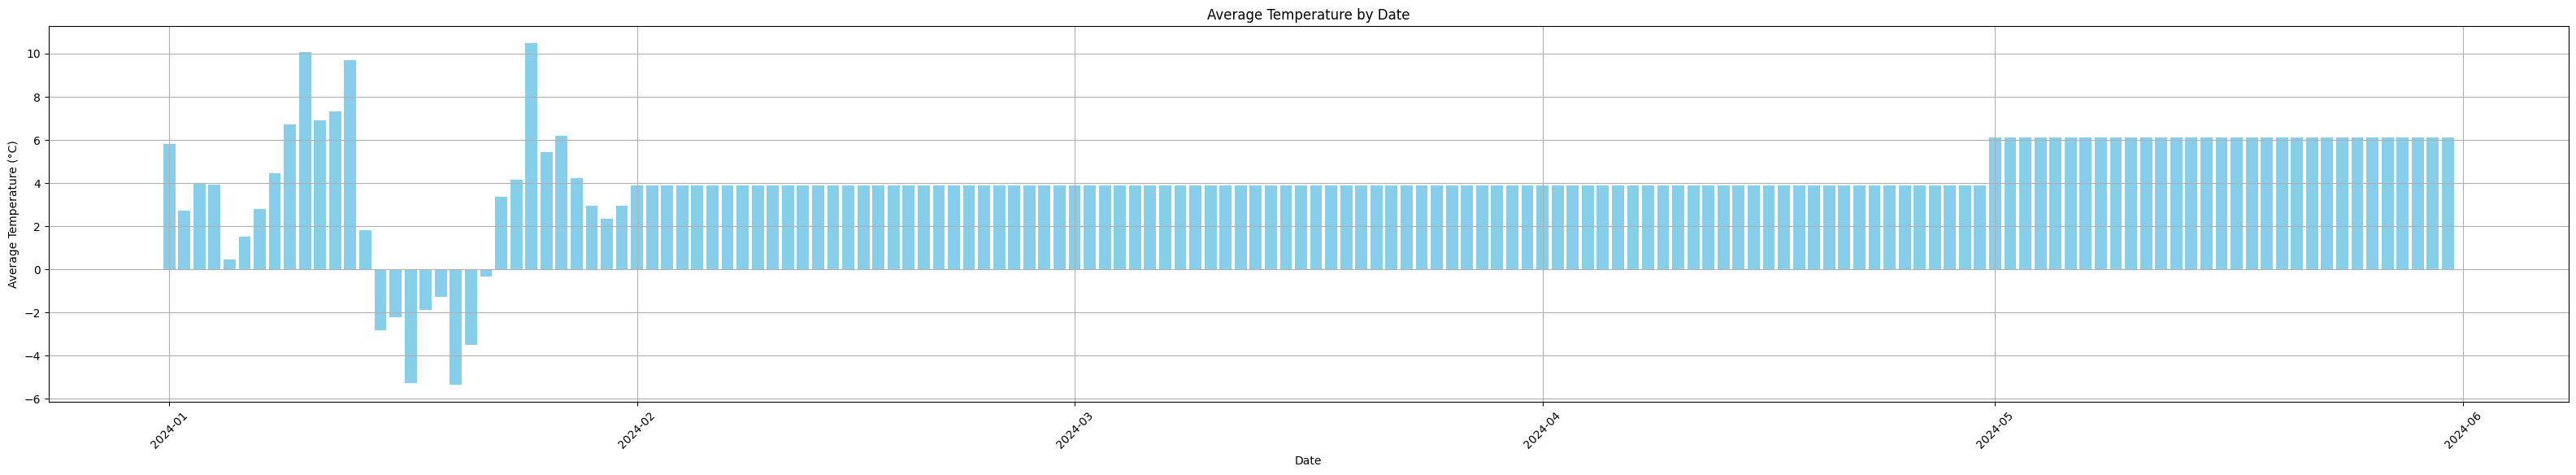

In [20]:
# 날씨 데이터 로드
weather_df = spark.read.csv('hdfs://hadoop-master:9000/user/root/data/jan_2024_weather_data.csv', header=True, inferSchema=True)

# 날짜 형식 변환
weather_df = weather_df.withColumn('Datetime', F.to_timestamp('Datetime'))
weather_df = weather_df.withColumn('date', F.to_date(weather_df['Datetime']))

# 하루의 대표 Condition과 평균 Temperature 계산
representative_condition = weather_df.groupBy('date') \
                                     .agg(F.expr('first(Condition)').alias('Condition'),
                                          F.avg('Temperature').alias('Average Temperature'))

representative_condition.show()

# 2023-01-01부터 2023-05-31까지의 데이터만 필터링
filtered_df = df.filter((F.col('tpep_pickup_datetime') >= '2023-01-01') & (F.col('tpep_pickup_datetime') <= '2023-05-31'))

# 날짜별로 그룹화하여 여행 수 계산
date_counts = filtered_df.withColumn('date', F.to_date('tpep_pickup_datetime')) \
                         .groupBy('date') \
                         .count()

# 날씨 데이터와 병합
merged_df = date_counts.join(representative_condition, on='date', how='outer')

merged_df.show()

# Condition별 레코드 수 계산 및 시각화
condition_counts = merged_df.groupBy('Condition').count().orderBy('count', ascending=False)

condition_counts_pandas = condition_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(condition_counts_pandas['Condition'], condition_counts_pandas['count'])
plt.title('Count of Records by Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Temperature별 레코드 수 계산 및 시각화
temperature_counts = merged_df.groupBy('Average Temperature').count().orderBy('Average Temperature')

temperature_counts_pandas = temperature_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(temperature_counts_pandas['Average Temperature'], temperature_counts_pandas['count'])
plt.title('Count of Records by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 날짜별 평균 기온 시각화
plt.figure(figsize=(40, 6))
result_pandas = representative_condition.toPandas()
plt.bar(result_pandas['date'], result_pandas['Average Temperature'], color='skyblue')
plt.title('Average Temperature by Date')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [21]:
# Parquet 형식으로 HDFS에 저장
hdfs_path = 'hdfs://hadoop-master:9000/user/root/output/result.parquet'
merged_df.write.parquet(hdfs_path)

print(f'Spark DataFrame successfully saved to HDFS at {hdfs_path}')

Spark DataFrame successfully saved to HDFS at hdfs://hadoop-master:9000/user/root/output/result.parquet
